<a href="https://colab.research.google.com/github/Junghwan-brian/Colab/blob/main/HierarchicalAttentionNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!nvidia-smi

Wed Dec  2 06:48:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |   1127MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm
from matplotlib import rc
import seaborn as sns
from collections import Counter
from tensorflow_addons.optimizers import SWA
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    GRU,
    Dense,
    TimeDistributed,
    Permute,
    Layer,
    RepeatVector,
    Bidirectional,
    Dropout,
    Input
)
from tensorflow.keras.models import Model
from warnings import filterwarnings
filterwarnings("ignore")
%matplotlib inline

batch_size = 256
seed = 0
valid_rate = 0.1  # validation 에 사용할 비율
max_length = 100  # seq 총 길이를 100(대략 75%)으로 맞춰준다.
max_sentences = 5  # 총 5개의 문장이라고 가정함.
attention_dim = 40
gru_dim=20

max_sentence_length = int(max_length / max_sentences)
np.random.seed(seed)
tf.random.set_seed(seed)


train = pd.read_csv('drive/MyDrive/HAN/data/train.txt')
test = pd.read_csv('drive/MyDrive/HAN/data/test.txt')

train = train.applymap(lambda x: x.split("|")[1:])
test = test.applymap(lambda x: x.split("|")[1:])

train_labels = train.applymap(lambda x: int(x[-1])).values.reshape((-1))
test_labels = test.applymap(lambda x: int(x[-1])).values.reshape((-1))

train_texts = train.applymap(lambda x: x[0])
test_texts = test.applymap(lambda x: x[0])

train_seq_len = train_texts.applymap(lambda x: len(x.split(" "))).values.reshape((-1))
train_texts = train_texts.applymap(lambda x: x.split(" ")).values.reshape((-1))
test_texts = test_texts.applymap(lambda x: x.split(" ")).values.reshape((-1))


def del_empty_space(texts, labels):
    for idx, text_list in enumerate(texts):
        """
        빈단어는 삭제해준다.
        """
        if "" in text_list:
            if len(text_list) == 1:
                texts = np.delete(texts, idx)
                labels = np.delete(labels, idx)
            else:
                text_list.remove("")
    return texts, labels


train_texts, train_labels = del_empty_space(train_texts, train_labels)
text_texts, test_labels = del_empty_space(test_texts, test_labels)

print(f"label class : {sorted(set(train_labels))}")  # 9개의 class 존재
print(f"시퀀스 단어 평균 갯수 : {np.mean(train_seq_len)}")  # 81


label class : [0, 1, 2, 3, 4, 5, 6, 7, 8]
시퀀스 단어 평균 갯수 : 81.31815128308477


In [26]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
rc('font', family=font_name)
fm._rebuild()

NanumGothic Eco


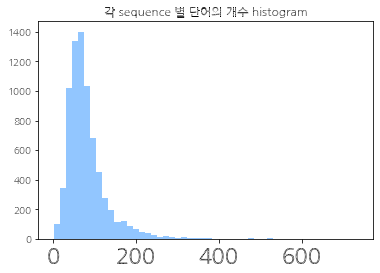

In [27]:
plt.style.use("seaborn-pastel")
plt.title("각 sequence 별 단어의 개수 histogram")
plt.hist(x=train_seq_len, bins=50)
plt.show()

In [28]:
word_counts = {}
for seq in train_texts:
    for word in seq:
        word = word.lower()
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# '경험', '개발' '서비스' 가 가장 많이 사용되었다.
# 1번 혹은 2번 사용된 단어들은 의미없는 단어가 대부분이라 제외한다.
sort_dict = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
print(sort_dict[:10])
print(sort_dict[-10:])

[('경험', 19460), ('개발', 15610), ('서비스', 10198), ('기획', 7159), ('운영', 6554), ('이상', 5958), ('업무', 5512), ('디자인', 5507), ('관리', 5488), ('이해', 5218)]
[('족도', 1), ('시소', 1), ('cashflow', 1), ('statements', 1), ('auditors', 1), ('capitalization', 1), ('financials', 1), ('receivable', 1), ('payable', 1), ('concentration', 1)]


In [6]:
except_count = 0
for count in np.array(sort_dict)[:, 1]:
    if int(count) < 3:
        except_count += 1

num_words = len(sort_dict) - except_count  # 7779개 단어 사용

tokenizer = text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_texts)

words_frequency = [w for w, c in tokenizer.word_counts.items() if c < 3]
# 빈도수가 3미만인 단어를 tokenizer 에서 제거.
for w in words_frequency:
    del tokenizer.word_index[w]
    del tokenizer.word_counts[w]

word_vocab = tokenizer.word_index
print(f"사용 단어 개수 : {len(word_vocab)}")

train_seq = tokenizer.texts_to_sequences(train_texts)
test_seq = tokenizer.texts_to_sequences(test_texts)

train_inputs = sequence.pad_sequences(train_seq, maxlen=max_length, padding="pre")
test_inputs = sequence.pad_sequences(test_seq, maxlen=max_length, padding="pre")

train_inputs = np.reshape(train_inputs, (-1, max_sentences, max_sentence_length))
test_inputs = np.reshape(test_inputs, (-1, max_sentences, max_sentence_length))
train_texts, val_texts, train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_texts , train_inputs, train_labels, random_state = seed, test_size = valid_rate, stratify = train_labels)

사용 단어 개수 : 7779


In [7]:
train_texts.shape, train_inputs.shape, train_labels.shape

((6697,), (6697, 5, 20), (6697,))

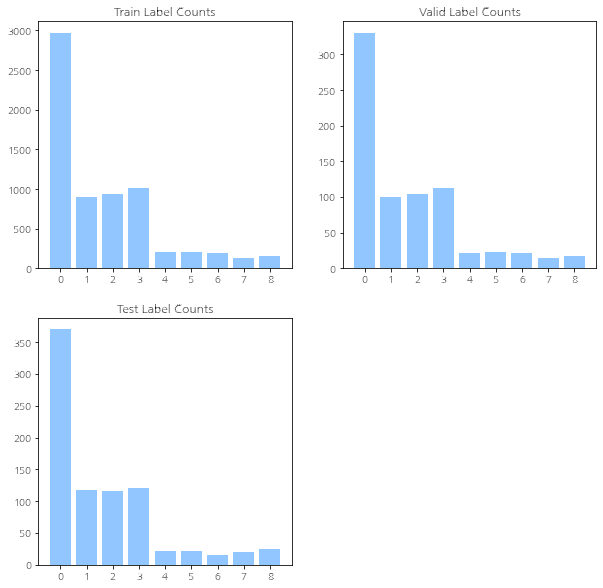

In [8]:
train_label_counts = np.array(list(Counter(train_labels).items()))
val_label_counts = np.array(list(Counter(val_labels).items()))
test_label_counts = np.array(list(Counter(test_labels).items()))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Train Label Counts")
plt.bar(x=train_label_counts[:, 0], height=train_label_counts[:, 1], width=0.8)
plt.xticks(np.arange(0,9))

plt.subplot(2,2,2)
plt.title("Valid Label Counts")
plt.bar(x=val_label_counts[:, 0], height=val_label_counts[:, 1], width=0.8)
plt.xticks(np.arange(0,9))

plt.subplot(2,2,3)
plt.title("Test Label Counts")
plt.bar(x=test_label_counts[:, 0], height=test_label_counts[:, 1], width=0.8)
plt.xticks(np.arange(0,9))

plt.show()

In [9]:
# 3개 미만인 것은 제외, skip-gram 사용
# embedding dimension은 200을 했을 때보다 100을 했을 때 더 나은 성능을 보인다.
embedding_model = Word2Vec(
    train_texts, size=100, window=2, min_count=3, workers=4, iter=100, sg=1, seed=seed
)
print(embedding_model.wv.most_similar(positive=["리눅스"], topn=3))

[('유닉스', 0.6252844333648682), ('Linux', 0.5750201940536499), ('proxy', 0.5504277944564819)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


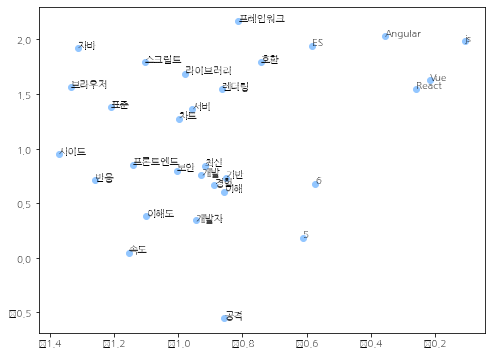

In [10]:
check = 30  # 30개만 확인
wv = embedding_model.wv
vocabs = wv.vocab.keys()
word_list = [wv[word] for word in vocabs]
pca = PCA(n_components=2)
xys = pca.fit_transform(word_list)[:check]
xs = xys[:, 0]
ys = xys[:, 1]
plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, marker="o")
for i, v in enumerate(list(vocabs)[:check]):
    plt.annotate(v, xy=(xs[i], ys[i]))
plt.show()

In [11]:

train_ds = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(
    batch_size
).shuffle(buffer_size=len(train_inputs), seed=seed).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(
    batch_size
)
a,b = next(iter(train_ds))
a.shape, b.shape

(TensorShape([256, 5, 20]), TensorShape([256]))

In [13]:
class AttentionLayer(Layer):
    """
    sentence & word attention layer
    """

    def __init__(self, attention_dim, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.dense1 = Dense(attention_dim, kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dense2 = Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001), use_bias=False)

    def call(self, x):
        """

        :param x: hidden state, shape = (batch,seq,features)
        :return:
        """
        u_it = tf.nn.tanh(self.dense1(x))  # batch, seq, attention_dim
        a_it = self.dense2(u_it)  # batch, seq, 1
        a_it = tf.squeeze(a_it, -1)
        a_it = tf.nn.softmax(a_it)  # batch, seq
        return a_it
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])



class RepresentationLayer(Layer):
    """
    sentence & word representation layer
    """

    def __init__(self, **kwargs):
        super(RepresentationLayer, self).__init__(**kwargs)

    def call(self, embedded, attention):
        """

        :param embedded: hidden state, shape = (batch,seq,features)
        :param attention: attention weights, shape = (batch,seq)
        :return:
        """
        repeated_attention = RepeatVector(gru_dim*2)(attention)  # batch, features, seq
        repeated_attention = Permute([2, 1])(repeated_attention)  # batch, seq, features
        representation = embedded * repeated_attention  # batch, seq, features
        representation = tf.reduce_sum(representation, axis=1)  # batch, features
        return representation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


class SentenceEncoder(Layer):
    def __init__(self, gru_dim, attention_dim, **kwargs):
        super(SentenceEncoder, self).__init__(**kwargs)
        self.gru_dim = gru_dim
        self.word2vec = embedding_model.wv.get_keras_embedding(train_embeddings=False)
        self.gru = Bidirectional(GRU(gru_dim, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    def call(self, x):
        embedding = self.word2vec(x)  # batch, max_sentence_length, embedding_dim
        x = self.gru(embedding)  # batch, max_sentence_length, gru_dim*2
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.gru_dim * 2)


# build a sentence encoder
sentence_input = Input(shape=(max_sentence_length, ), dtype='int32')
embedded_sentence = SentenceEncoder(gru_dim, attention_dim)(sentence_input)

# word attention computation
word_attention = AttentionLayer(attention_dim)(embedded_sentence)
sentence_representation = RepresentationLayer()(embedded_sentence, word_attention)
sentence_encoder = Model(inputs=[sentence_input], outputs=[sentence_representation])

# build a document encoder
document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
embedded_document = TimeDistributed(sentence_encoder)(document_input)
embedded_document = Bidirectional(GRU(gru_dim, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))(embedded_document)

# sentence attention computation
sentence_attention = AttentionLayer(attention_dim)(embedded_document)
document_representation = RepresentationLayer()(embedded_document, sentence_attention)

# fully connected layers
dropout = Dropout(0.2, seed=seed)(document_representation)
dense1 = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu')(dropout)
output = Dense(9, kernel_regularizer=tf.keras.regularizers.l2(0.02), activation="softmax")(dense1)

model = Model(inputs=[document_input],outputs=[output])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 20)]      0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 40)        849620      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 5, 40)        7440        time_distributed_1[0][0]         
__________________________________________________________________________________________________
attention_layer_3 (AttentionLay (None, 5)            1680        bidirectional_3[0][0]            
_______________________________________________________________________________________

In [14]:

# critical success index - TP/(TP+FP+FN)
def single_class_csi(interesting_class_id):
    def csi(y_true, y_pred):
        class_id_true = tf.cast(y_true, tf.int64)
        class_id_pred = tf.math.argmax(y_pred, axis=-1)
        # 전체 양성수(TP+FN)
        real_positive = tf.cast(
            tf.math.equal(class_id_true, interesting_class_id), "int32"
        )
        # 양성이라고 판정한 수(TP+FP)
        pred_positive = tf.cast(
            tf.math.equal(class_id_pred, interesting_class_id), "int32"
        )
        # 검출 양성수(TP)
        true_positive = (
            tf.cast(tf.math.equal(class_id_true, class_id_pred), "int32")
            * real_positive
        )
        tp_fp_fn = real_positive + pred_positive - true_positive
        # TP/(TP+FP+FN)
        class_csi = tf.cast(tf.math.reduce_sum(true_positive), "float32") / tf.cast(
            tf.math.maximum(tf.math.reduce_sum(tp_fp_fn), 1), "float32"
        )
        return class_csi

    return csi


CSI0 = single_class_csi(0)
CSI1 = single_class_csi(1)
CSI2 = single_class_csi(2)
CSI3 = single_class_csi(3)
CSI4 = single_class_csi(4)
CSI5 = single_class_csi(5)
CSI6 = single_class_csi(6)
CSI7 = single_class_csi(7)
CSI8 = single_class_csi(8)


@tf.function
def train_step(
    model, inputs, labels, loss_object, optimizer, train_loss, train_accuracy
):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)
    return predictions

@tf.function
def test_step(
    model, inputs, labels, loss_object, test_loss, test_accuracy
):
    predictions = model(inputs, training=False)
    loss = loss_object(labels, predictions)
    test_loss(loss)
    test_accuracy(labels, predictions)
    return predictions

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(name='loss_obj')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_acc')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_acc')

sgd = tf.optimizers.SGD(learning_rate = 0.1, momentum=0.9)
optimizer = SWA(sgd, start_averaging = 3, average_period = 5)
for epoch in range(20):
    print(f"\nEpoch : {epoch+1}")
    for inputs, labels in train_ds:
        predictions = train_step(model,inputs, labels, loss_object, optimizer, train_loss, train_accuracy)
    template1 = f"Loss:{train_loss.result():.3f}, Accuracy:{train_accuracy.result()*100:.3f}"
    print("\nTrain")
    print(template1)
    print(f"CSI0 : {CSI0(labels,predictions):.3f}")
    print(f"CSI1 : {CSI1(labels,predictions):.3f}")
    print(f"CSI2 : {CSI2(labels,predictions):.3f}")
    print(f"CSI3 : {CSI3(labels,predictions):.3f}")
    print(f"CSI4 : {CSI4(labels,predictions):.3f}")
    print(f"CSI5 : {CSI5(labels,predictions):.3f}")
    print(f"CSI6 : {CSI6(labels,predictions):.3f}")
    print(f"CSI7 : {CSI7(labels,predictions):.3f}")
    print(f"CSI8 : {CSI8(labels,predictions):.3f}")
    for inputs, labels in valid_ds:
        predictions = test_step(model, inputs, labels, loss_object, test_loss, test_accuracy)
    
    print("\nTest")
    template2 = f"Loss:{test_loss.result():.3f}, Accuracy:{test_accuracy.result()*100:.3f}"
    print(template2)
    print(f"CSI0 : {CSI0(labels,predictions):.3f}")
    print(f"CSI1 : {CSI1(labels,predictions):.3f}")
    print(f"CSI2 : {CSI2(labels,predictions):.3f}")
    print(f"CSI3 : {CSI3(labels,predictions):.3f}")
    print(f"CSI4 : {CSI4(labels,predictions):.3f}")
    print(f"CSI5 : {CSI5(labels,predictions):.3f}")
    print(f"CSI6 : {CSI6(labels,predictions):.3f}")
    print(f"CSI7 : {CSI7(labels,predictions):.3f}")
    print(f"CSI8 : {CSI8(labels,predictions):.3f}")

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()


Epoch : 1

Train
Loss:1.811, Accuracy:39.884
CSI0 : 0.441
CSI1 : 0.000
CSI2 : 0.000
CSI3 : 0.000
CSI4 : 0.000
CSI5 : 0.000
CSI6 : 0.000
CSI7 : 0.000
CSI8 : 0.000

Test
Loss:1.687, Accuracy:44.295
CSI0 : 0.472
CSI1 : 0.000
CSI2 : 0.000
CSI3 : 0.000
CSI4 : 0.000
CSI5 : 0.000
CSI6 : 0.000
CSI7 : 0.000
CSI8 : 0.000

Epoch : 2

Train
Loss:1.677, Accuracy:44.318
CSI0 : 0.434
CSI1 : 0.000
CSI2 : 0.000
CSI3 : 0.000
CSI4 : 0.000
CSI5 : 0.000
CSI6 : 0.000
CSI7 : 0.000
CSI8 : 0.000

Test
Loss:1.660, Accuracy:44.295
CSI0 : 0.472
CSI1 : 0.000
CSI2 : 0.000
CSI3 : 0.000
CSI4 : 0.000
CSI5 : 0.000
CSI6 : 0.000
CSI7 : 0.000
CSI8 : 0.000

Epoch : 3

Train
Loss:1.664, Accuracy:44.318
CSI0 : 0.418
CSI1 : 0.000
CSI2 : 0.000
CSI3 : 0.000
CSI4 : 0.000
CSI5 : 0.000
CSI6 : 0.000
CSI7 : 0.000
CSI8 : 0.000

Test
Loss:1.643, Accuracy:44.295
CSI0 : 0.472
CSI1 : 0.000
CSI2 : 0.000
CSI3 : 0.000
CSI4 : 0.000
CSI5 : 0.000
CSI6 : 0.000
CSI7 : 0.000
CSI8 : 0.000

Epoch : 4

Train
Loss:1.613, Accuracy:44.378
CSI0 : 0.480

In [15]:
test_pred = model(test_inputs)
test_loss = loss_object(test_labels,test_pred)
test_acc = tf.keras.metrics.SparseCategoricalAccuracy()(test_labels,test_pred)
print(f"Test Loss : {test_loss}:.3f")
print(f"Test Accuracy : {test_acc}:.3f")
print(f"CSI0 : {CSI0(test_labels,test_pred):.3f}")
print(f"CSI1 : {CSI1(test_labels,test_pred):.3f}")
print(f"CSI2 : {CSI2(test_labels,test_pred):.3f}")
print(f"CSI3 : {CSI3(test_labels,test_pred):.3f}")
print(f"CSI4 : {CSI4(test_labels,test_pred):.3f}")
print(f"CSI5 : {CSI5(test_labels,test_pred):.3f}")
print(f"CSI6 : {CSI6(test_labels,test_pred):.3f}")
print(f"CSI7 : {CSI7(test_labels,test_pred):.3f}")
print(f"CSI8 : {CSI8(test_labels,test_pred):.3f}")

Test Loss : 0.42666032910346985:.3f
Test Accuracy : 0.8681983351707458:.3f
CSI0 : 0.894
CSI1 : 0.880
CSI2 : 0.780
CSI3 : 0.558
CSI4 : 0.667
CSI5 : 0.571
CSI6 : 0.474
CSI7 : 0.480
CSI8 : 0.258


In [16]:
word_rev_index = {}
for word, i in word_vocab.items():
    word_rev_index[i] = word

word_attention_extractor = Model(inputs=[sentence_input],
                                 outputs=[word_attention])

word_attentions = TimeDistributed(word_attention_extractor)(document_input)

attention_extractor = Model(inputs=[document_input],
                            outputs=[word_attentions, sentence_attention])

def sentiment_analysis(tokenized_sentences):    
    # word attention만 가져오기
    word_att, sentence_att = attention_extractor.predict(np.asarray([test_inputs[0]]))
    pred_attention = word_att[0]
    for i, sentence in enumerate(test_inputs[0]):
        words = [word_rev_index[word_id] for word_id in sentence if word_id != 0][:50]
        pred_att = np.asarray(pred_attention[i][::-1][:len(words)][::-1])
        pred_att = np.expand_dims(pred_att, axis=0)

        fig, ax = plt.subplots(figsize=(len(words), 2))
        plt.rc('xtick', labelsize=22)
        heatmap = sns.heatmap(pred_att, xticklabels=words, square=True, linewidths=0.1)
        plt.xticks(rotation=70)
        plt.show()

In [17]:
sentiment_idx = []
labels = []
for idx, label in enumerate(test_labels):
    if label not in labels:
        sentiment_idx.append(idx)
        labels.append(label)
    if len(sentiment_idx) == 9:
        break
sentiment_idx

[0, 1, 4, 10, 15, 21, 33, 34, 60]

Label : 4 


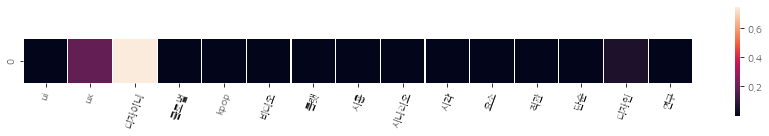

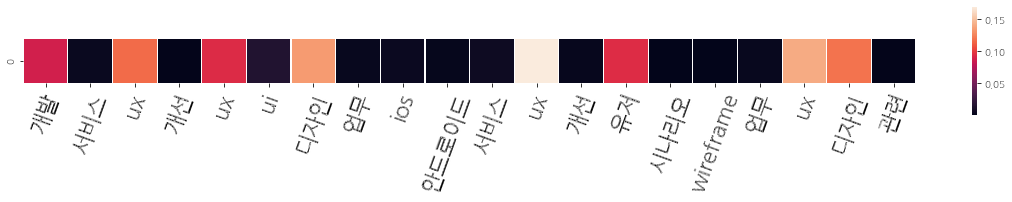

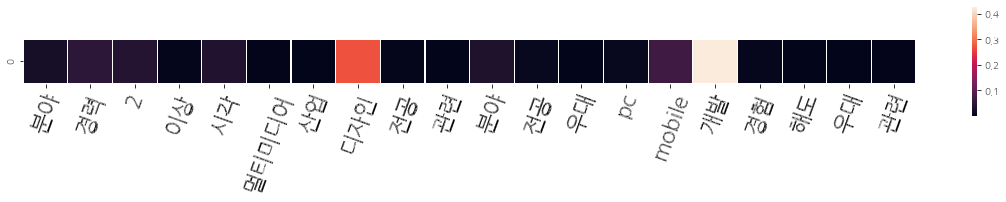

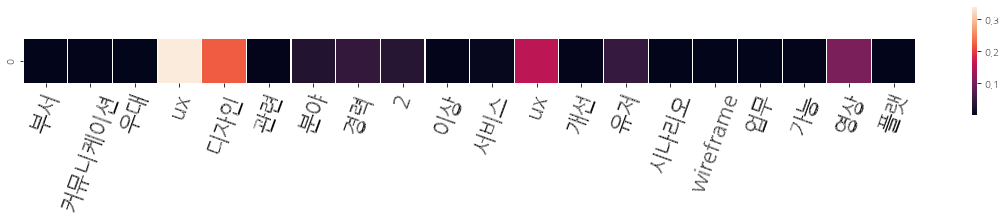

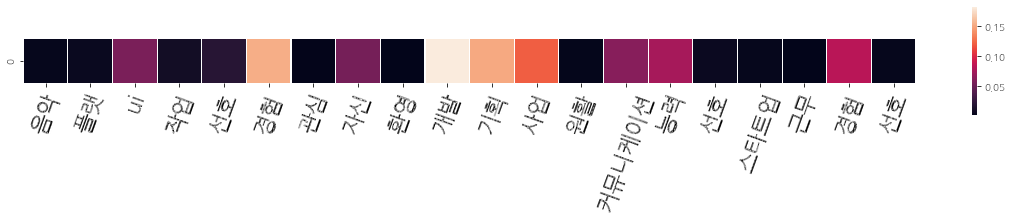

In [19]:
num = 8
idx = sentiment_idx[num]
print(f"Label : {test_labels[idx]} ")
sentiment_analysis(test_texts[idx])